https://www.kaggle.com/ogrellier/i-have-seen-the-future (+)

https://www.kaggle.com/karkun/sergey-ivanov-msu-mmp

https://www.kaggle.com/ambitious/leaky-homework-khrylchenko-kirill-msu-mmp

https://www.kaggle.com/igauty/story-of-a-leak-v01

https://www.kaggle.com/trrrrrrrrrrrrt/bibik-mmp-msu-for-learning-purposes

https://www.kaggle.com/satian/story-of-a-leak

https://www.kaggle.com/maxbourdon/kodryan-mmp-msu-gacrp-my-best

https://www.kaggle.com/lipann/fork-of-data-analysis-fe-lgbm-only-fe-mmp-msu

https://www.kaggle.com/lipann/data-analysis-fe-lgbm-mmp-msu

https://www.kaggle.com/snekman/schekalev-hw-mmp-msu

https://www.kaggle.com/zzerozz/lgbm-xgboost-fork-of-i-have-seen-the-future

https://www.kaggle.com/alekseydumbay/i-have-seen-the-future-modification-for-learning

https://www.kaggle.com/ashishpatel26/future-is-here

https://www.kaggle.com/ogrellier/using-classification-for-predictions

Test by train. Train by test

Classification for prediction

Find discussion about sessionId

Случайные блуждания по графу решений

Использовать идею о том, что новые значения важнее предыдущих (добавить веса)

In [1]:
import pandas as pd
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold

import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm_notebook

import gc

fontsize = 18

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('../data/ga-customer-revenue-prediction/prepared_train.csv')
test = pd.read_csv('../data/ga-customer-revenue-prediction/prepared_test.csv')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train['fullVisitorId'] = train['fullVisitorId'].apply(lambda row: row[1:])
test['fullVisitorId'] = test['fullVisitorId'].apply(lambda row: row[1:])

In [3]:
unique_vis = np.array(sorted(train['fullVisitorId'].unique()))
np.arange(train.shape[0])
folds = GroupKFold(n_splits=5)
unique_vis.shape

(714167,)

In [4]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [5]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']
    
del train['sessionId_0']
del train['sessionId_1']

del test['sessionId_0']
del test['sessionId_1']

In [6]:
train['target'] = y_reg
for df in [train, test]:
    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
    df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(1)
    ).astype(np.int64)

In [7]:
train['target'] = y_reg
for df in [train, test]:
    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
    df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)
    
    df['next_session_1'] = df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(1)
    df['next_session_1'] = df['next_session_1'].replace(pd.NaT, pd.Timedelta(0)).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(-1)
    df['next_session_2'] = df['next_session_2'].replace(pd.NaT, pd.Timedelta(0)).astype(np.int64) // 1e9 // 60 // 60
    
    df['max_visits'] = df['fullVisitorId'].map(
        df[['fullVisitorId', 'visitNumber']].groupby('fullVisitorId')['visitNumber'].max()
    )
    
    df['nb_pageviews'] = df['date'].map(
        df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum()
    )
    
    df['ratio_pageviews'] = df['totals.pageviews'] / df['nb_pageviews']
    
    df['nb_sessions'] = df['date'].map(
        df[['date']].groupby('date').size()
    )
    
    df['nb_sessions_28_ma'] = df['date'].map(
        df[['date']].groupby('date').size().rolling(28, min_periods=7, center=True).mean()
    )

    df['nb_sessions_28_ma'] = df['nb_sessions'] / df['nb_sessions_28_ma']

    df['nb_sessions_per_day'] = df['date'].map(
        df[['date']].groupby('date').size()
    )
    
    df['nb_visitors_per_day'] = df['date'].map(
        df[['date','fullVisitorId']].groupby('date')['fullVisitorId'].nunique()
    )

y_reg = train['target']
del train['target']

In [8]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

In [9]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [10]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['Unnamed: 0', 'channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom', 'next_session_1', 'next_session_2', 'nb_pageviews', 'ratio_pageviews', 'nb_sessions_28_ma', 'nb_sessions_per_day', 'nb_visitors_per_day']
Training until validation scores don't imp

1.5994552778047977

In [11]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [12]:
# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [13]:
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [14]:
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
full_data.shape

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


(714167, 323)

In [15]:
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [18]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


(617242, 323)

In [16]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [ ]:
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    print(imp_df.shape, val_x.shape)
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52419	TRAIN's l2: 2.32315	VALID's rmse: 1.58217	VALID's l2: 2.50326
[200]	TRAIN's rmse: 1.48576	TRAIN's l2: 2.20747	VALID's rmse: 1.57975	VALID's l2: 2.49561
Early stopping, best iteration is:
[150]	TRAIN's rmse: 1.50047	TRAIN's l2: 2.25141	VALID's rmse: 1.57898	VALID's l2: 2.49317
(323, 3) (142834, 323)
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52261	TRAIN's l2: 2.31834	VALID's rmse: 1.5826	VALID's l2: 2.50464
[200]	TRAIN's rmse: 1.48257	TRAIN's l2: 2.19803	VALID's rmse: 1.57928	VALID's l2: 2.49413
Early stopping, best iteration is:
[151]	TRAIN's rmse: 1.49755	TRAIN's l2: 2.24264	VALID's rmse: 1.57891	VALID's l2: 2.49294
(323, 3) (142834, 323)
Training until validation scores don't improve for 50 rounds.


/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


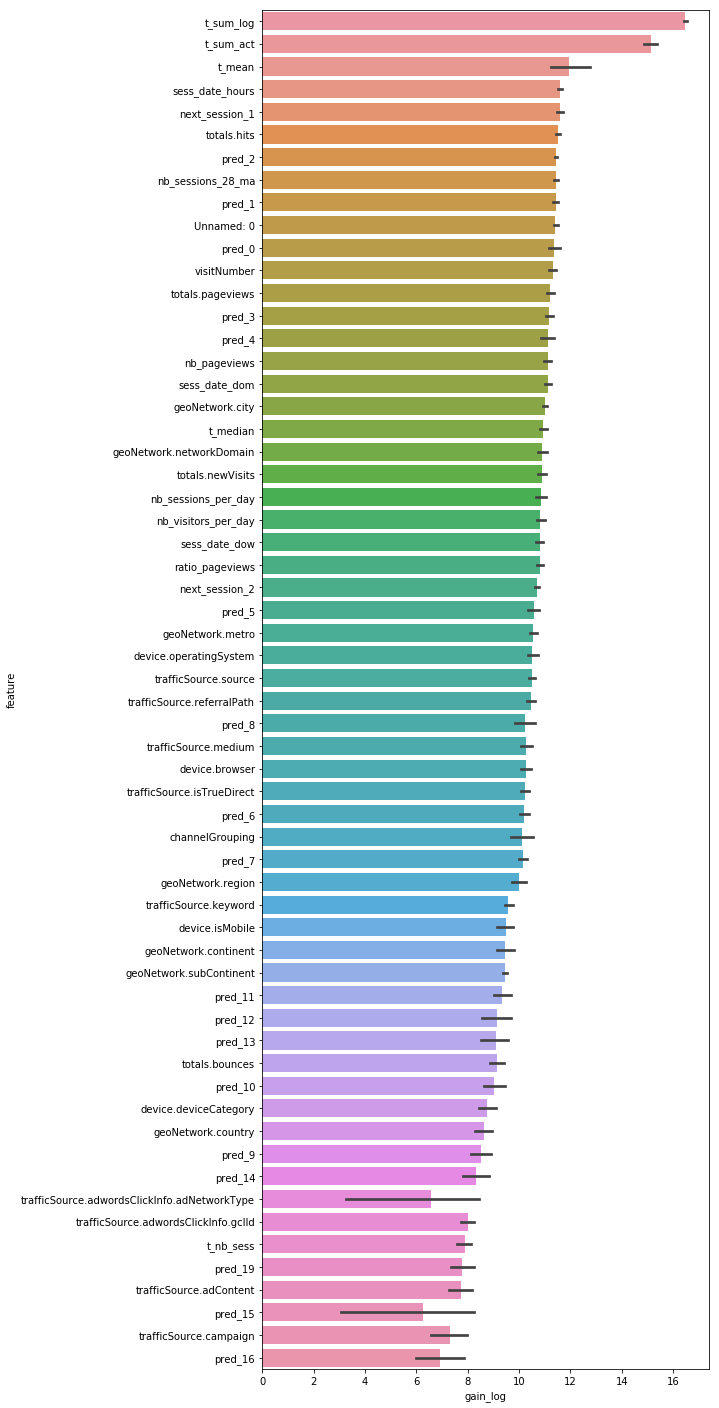

In [23]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [25]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('../data/ga-customer-revenue-prediction/17.10.2018.csv', index=True)

# Modify 1

In [60]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = 
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

MemoryError: 